# Modeling COVID-19 epidemic with Python - Regional Breakdown
To be documented 

In [317]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.metrics import max_error
import math
import numpy as np
from sklearn import linear_model

In [318]:
model_score_threshold = 0.95

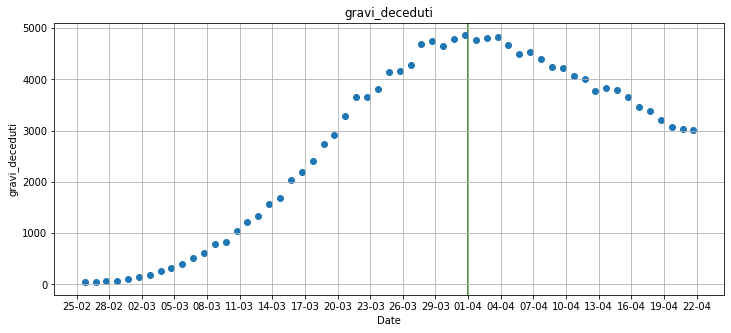

In [319]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
data['diff_deceduti'] = data['deceduti'].diff()

data['gravi_deceduti'] = data['diff_deceduti'] + data['terapia_intensiva']
variable = 'gravi_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()


Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en', 'diff_deceduti', 'gravi_deceduti'],
      dtype='object')
Creating model for Abruzzo
Score : 0.9709877300302294


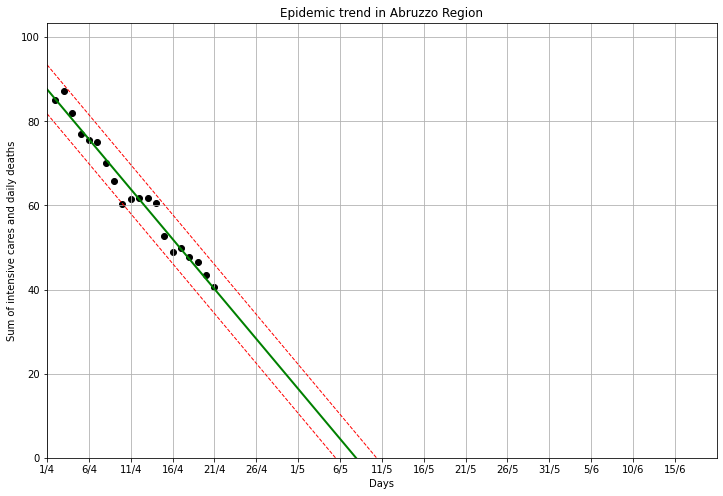

Abruzzo Zero intensive cares and deaths expected between 11/05/2020 and 05/05/2020: 37.0

Creating model for Basilicata
Score : 0.9645381926838621


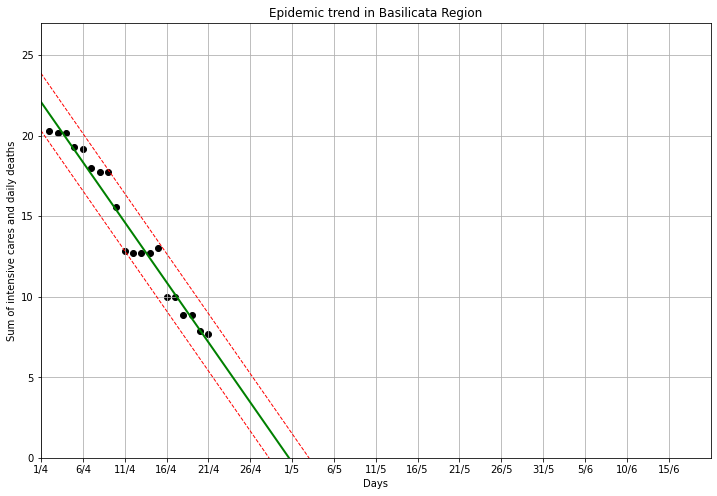

Basilicata Zero intensive cares and deaths expected between 04/05/2020 and 28/04/2020: 30.0

Creating model for Calabria
Score : 0.9277882524121029
Calabria Zero intensive cares and deaths expected between 04/05/2020 and 26/04/2020: 29.0

Creating model for Campania
Score : 0.9468676339139176
Campania Zero intensive cares and deaths expected between 15/05/2020 and 09/05/2020: 41.0

Creating model for Emilia-Romagna
Score : 0.9566237317595447


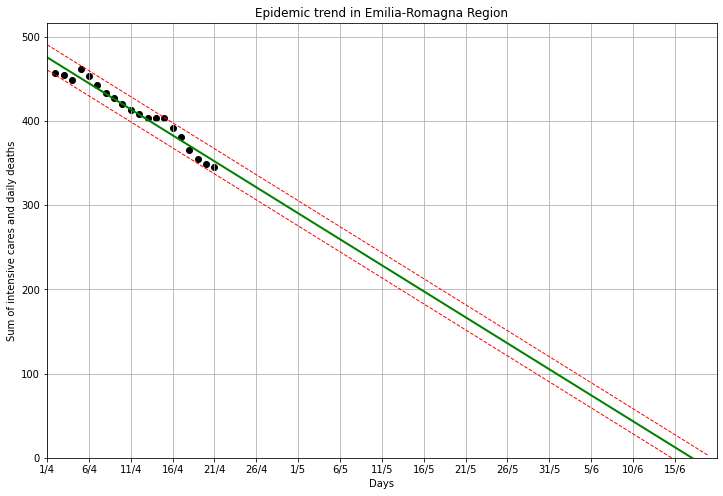

Emilia-Romagna Zero intensive cares and deaths expected between 20/06/2020 and 14/06/2020: 77.0

Creating model for Friuli Venezia Giulia
Score : 0.88462868442894
Friuli Venezia Giulia Zero intensive cares and deaths expected between 05/05/2020 and 26/04/2020: 30.0

Creating model for Lazio
Score : 0.13356596444723257
Lazio Zero intensive cares and deaths expected between 02/10/2021 and 20/07/2021: 512.0

Creating model for Liguria
Score : 0.9378924740282805
Liguria Zero intensive cares and deaths expected between 21/05/2020 and 12/05/2020: 45.0

Creating model for Lombardia
Score : 0.9953000598829841


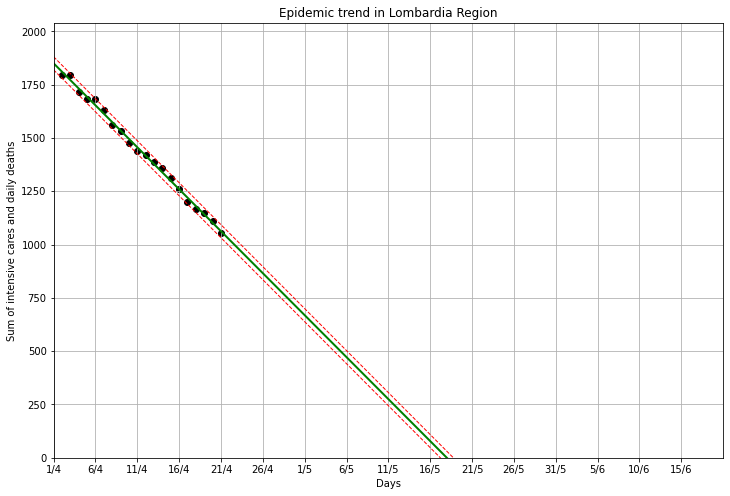

Lombardia Zero intensive cares and deaths expected between 19/05/2020 and 17/05/2020: 47.0

Creating model for Marche
Score : 0.9820747890429938


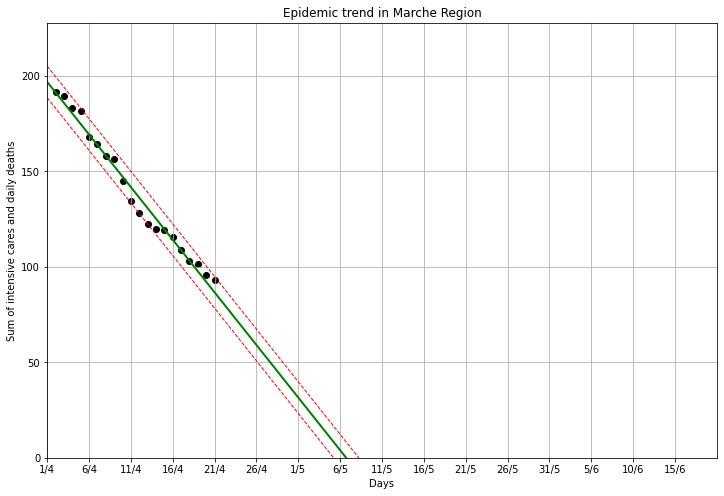

Marche Zero intensive cares and deaths expected between 09/05/2020 and 05/05/2020: 36.0

Creating model for Molise
Score : 0.7279204359964316
Molise Zero intensive cares and deaths expected between 11/05/2020 and 26/04/2020: 32.0

Creating model for P.A. Bolzano
Score : 0.8773563327776357
P.A. Bolzano Zero intensive cares and deaths expected between 04/05/2020 and 26/04/2020: 29.0

Creating model for P.A. Trento
Score : 0.9561886562525023


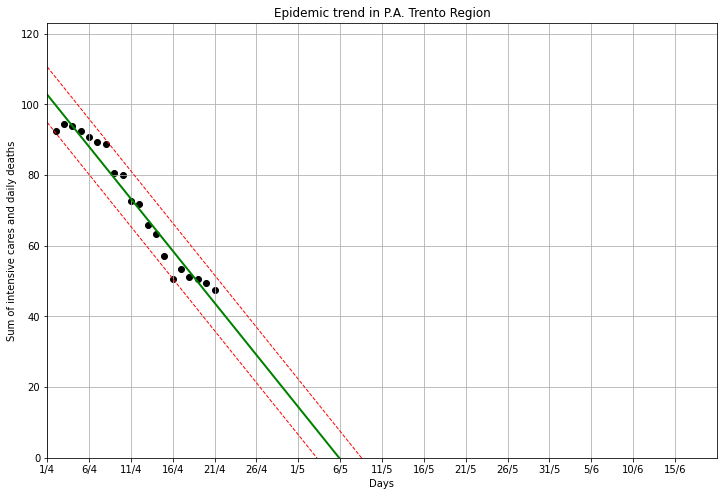

P.A. Trento Zero intensive cares and deaths expected between 09/05/2020 and 03/05/2020: 35.0

Creating model for Piemonte
Score : 0.9586838231791185


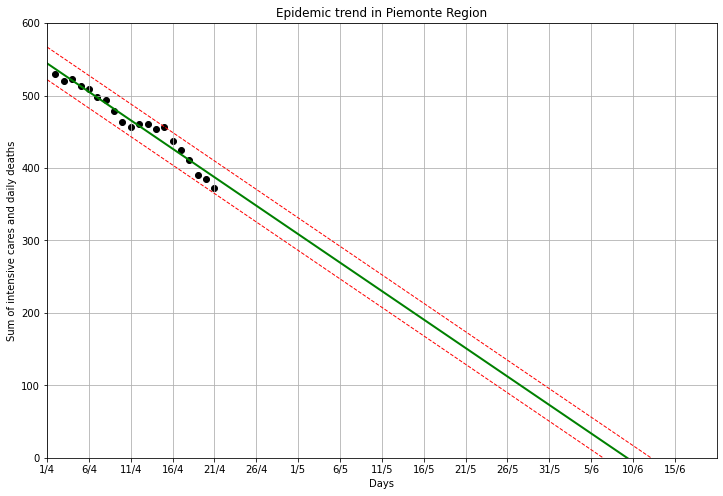

Piemonte Zero intensive cares and deaths expected between 13/06/2020 and 06/06/2020: 69.0

Creating model for Puglia
Score : 0.7062826175783761
Puglia Zero intensive cares and deaths expected between 14/05/2020 and 22/04/2020: 32.0

Creating model for Sardegna
Score : 0.21996116077204209
Sardegna Zero intensive cares and deaths expected between 06/09/2020 and 13/07/2020: 131.0

Creating model for Sicilia
Score : 0.9716312549215014


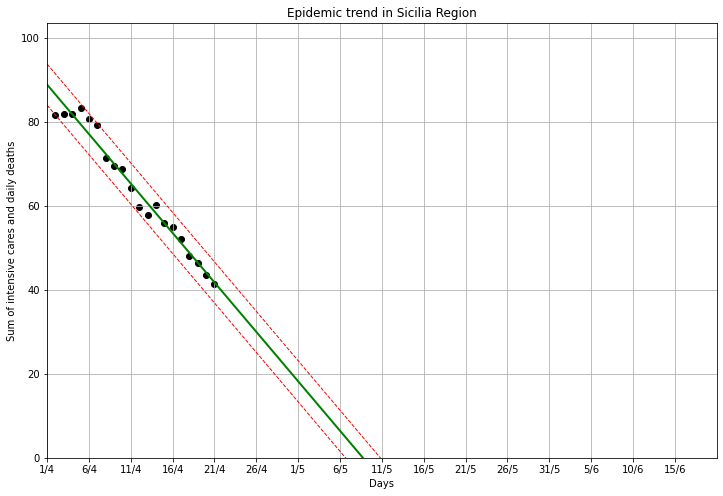

Sicilia Zero intensive cares and deaths expected between 11/05/2020 and 06/05/2020: 38.0

Creating model for Toscana
Score : 0.9782429359337463


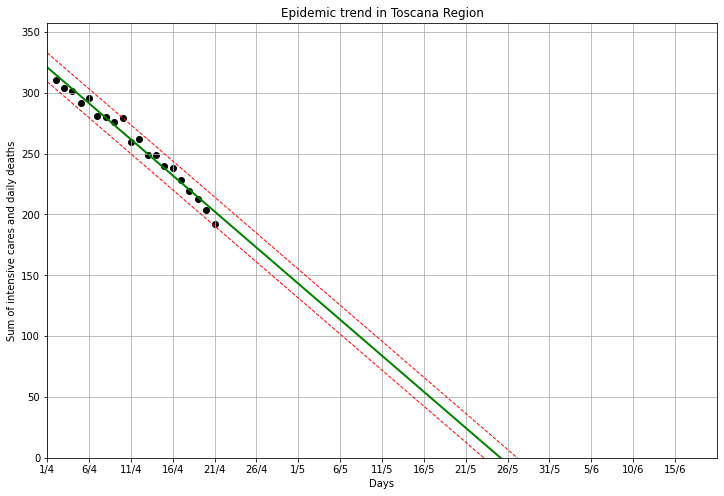

Toscana Zero intensive cares and deaths expected between 28/05/2020 and 23/05/2020: 54.0

Creating model for Umbria
Score : 0.9375843470622063
Umbria Zero intensive cares and deaths expected between 19/05/2020 and 10/05/2020: 44.0

Creating model for Valle d'Aosta
Score : 0.9732369662125835


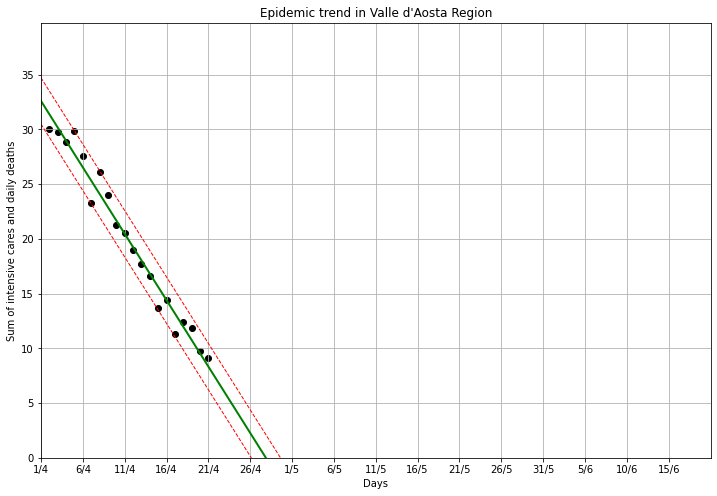

Valle d'Aosta Zero intensive cares and deaths expected between 30/04/2020 and 26/04/2020: 27.0

Creating model for Veneto
Score : 0.9811869420413734


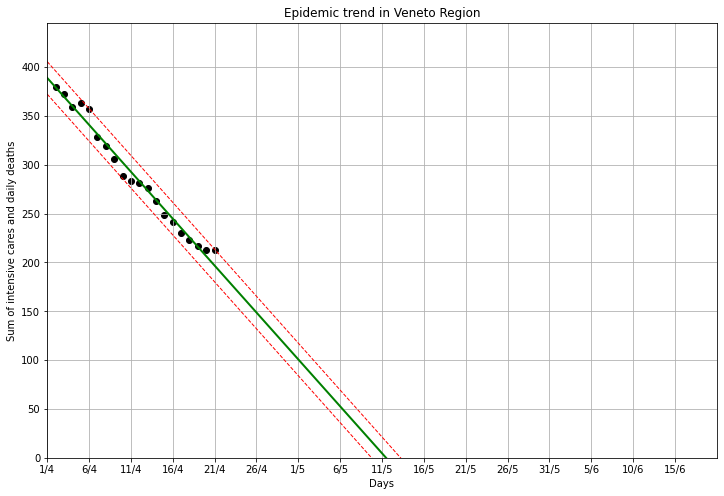

Veneto Zero intensive cares and deaths expected between 14/05/2020 and 09/05/2020: 40.0

              region_name  COD_REG  remaining_days   data_zero data_zero_max  \
13                Abruzzo       13              15  08/05/2020    11/05/2020   
17             Basilicata       17               8  01/05/2020    04/05/2020   
18               Calabria       18               7  30/04/2020    04/05/2020   
15               Campania       15              19  12/05/2020    15/05/2020   
8          Emilia-Romagna        8              55  17/06/2020    20/06/2020   
6   Friuli Venezia Giulia        6               8  01/05/2020    05/05/2020   
12                  Lazio       12             490  26/08/2021    02/10/2021   
7                 Liguria        7              23  16/05/2020    21/05/2020   
3               Lombardia        3              25  18/05/2020    19/05/2020   
11                 Marche       11              14  07/05/2020    09/05/2020   
14                 Molise      

In [320]:
def n_to_date(n):
    # it converts a number to a date, considering starting from starting_date
    return (date_zero + timedelta(days=n - starting_date)).strftime('%d/%m/%Y')


def build_line(x1, y1, x2, y2):
    m = float(y2 - y1) / (x2 - x1)
    q = y1 - (m * x1)
    return [m, q]


civil_protection_data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")

print(data.columns)
rolling_average_days = 7

regional_df_list = []
for region, data_region_subset in civil_protection_data.groupby('denominazione_regione'):
    data_region = data_region_subset.copy()
    data_region['diff_deceduti'] = data_region['deceduti'].diff().rolling(window=rolling_average_days).mean()
    data_region['gravi_deceduti'] = data_region['diff_deceduti'] + data_region['terapia_intensiva']
    regional_df_list.append(data_region)

model_outputs_df = pd.DataFrame()

for data in regional_df_list:
    date = data['data']
    region_name = data["denominazione_regione"].iloc[0]
    region_code = data["codice_regione"].iloc[0]
    print("Creating model for " + region_name)
    date_format = [pd.to_datetime(d) for d in date]
    # prepare the lists for the model
    X = date_format
    y = data['gravi_deceduti'].tolist()[1:]
    # date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
    starting_date = 37  # April 1st is the 37th day of the series
    day_numbers = []
    for i in range(1, len(X)):
        day_numbers.append([i])
    X = day_numbers
    # # let's train our model only with data after the peak
    X = X[starting_date:]
    y = y[starting_date:]
    # Instantiate Linear Regression
    linear_regr = linear_model.LinearRegression()
    # Train the model using the training sets
    linear_regr.fit(X, y)
    model_score = linear_regr.score(X, y)
    print("Score : %s" % (model_score))
    if model_score > 0.095:
        # Predict future trend
        y_pred = linear_regr.predict(X)
        error = max_error(y, y_pred)
        error
        X_test = []
        future_days = 80

        for i in range(starting_date, starting_date + future_days):
            X_test.append([i])
        y_pred_linear = linear_regr.predict(X_test)
        y_pred_max = []
        y_pred_min = []
        for i in range(0, len(y_pred_linear)):
            y_pred_max.append(y_pred_linear[i] + error)
            y_pred_min.append(y_pred_linear[i] - error)

        # convert date 0 into datetime format

        date_zero = datetime.strptime(data['data'].iloc[starting_date], '%Y-%m-%dT%H:%M:%S')
        # date forecast
        date_prev = []
        x_ticks = []
        step = 5
        data_curr = date_zero
        x_current = starting_date
        n = int(future_days / step)
        for i in range(0, n):
            date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
            x_ticks.append(x_current)
            data_curr = data_curr + timedelta(days=step)
            x_current = x_current + step

        if model_score >= model_score_threshold: 
            plt.title("Epidemic trend in %s Region" % region_name)
            # adjust plot size
            F = plt.gcf()
            Size = F.get_size_inches()
            F.set_size_inches(Size[0] * 2, Size[1] * 2, forward=True)
            # plot known data
            plt.scatter(X, y, color='black')
            # plot linear regression prediction
            plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
            # plot maximum error
            plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
            # plot minimum error
            plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
            plt.xlabel('Days')
            plt.xlim(starting_date, starting_date + future_days)
            plt.ylim(bottom=0)
            plt.xticks(x_ticks, date_prev)
            plt.ylabel('Sum of intensive cares and daily deaths')
            # plt.yscale("log")
            # add grid
            plt.grid()
            plt.savefig("prediction.png")
            plt.show()


        data_zero = round(- linear_regr.intercept_ / linear_regr.coef_[0])
        date_zero_format = n_to_date(data_zero)
        today = datetime.today()
        future = date_zero + timedelta(days=data_zero - starting_date)
        remaining_days = (future - today).days

        line_max = build_line(X_test[0][0], y_pred_max[0], X_test[1][0], y_pred_max[1])
        data_zero_max = math.ceil(- line_max[1] / line_max[0])
        data_zero_max = n_to_date(data_zero_max)

        line_min = build_line(X_test[0][0], y_pred_min[0], X_test[1][0], y_pred_min[1])
        data_zero_min = math.floor(- line_min[1] / line_min[0])
        data_zero_min = n_to_date(data_zero_min)
        print("%s Zero intensive cares and deaths expected between %s and %s: %s" % (region_name, data_zero_max, data_zero_min, data_zero - starting_date))

        print("")

        temp = pd.DataFrame(
            {
                'region_name': region_name,
                'COD_REG': int(region_code),
                'remaining_days': remaining_days,
                'data_zero': date_zero_format,
                'data_zero_max': data_zero_max,
                'data_zero_min': data_zero_max,
                'model_score': model_score
            }, index=[region_code]
        )

        model_outputs_df = pd.concat([model_outputs_df, temp])

print (model_outputs_df)

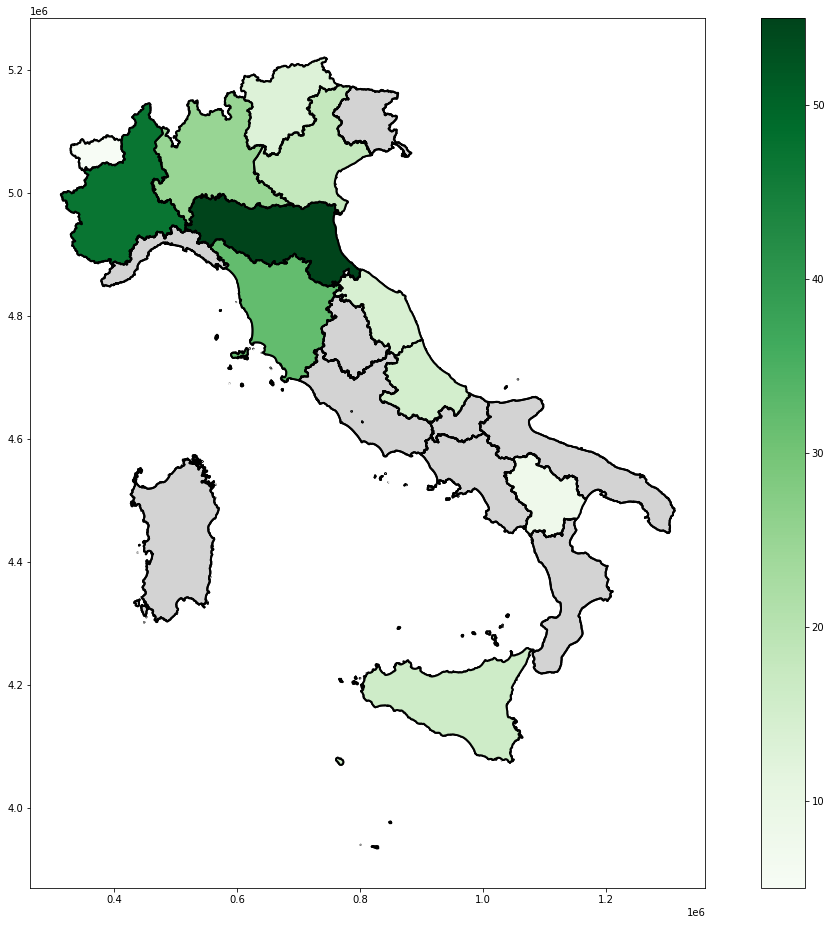

In [321]:
import geopandas as gpd
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/Reg01012018_g",'Reg01012018_g_WGS84.shp'))
background = df
model_outputs_df_filtered = model_outputs_df[model_outputs_df['model_score'] > model_score_threshold]
df = df.merge(model_outputs_df_filtered, on='COD_REG')
fig, ax = plt.subplots(figsize = (20,16)) 
background.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax) #Use your second dataframe
background.plot(color='lightgray',edgecolor='k',linewidth = 2,ax=ax, legend=True) #Use your second dataframe
df.plot(column = 'remaining_days',cmap = 'Greens',ax=ax, legend=True)